In [2]:
from time import time

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms

import Onlinehd

SEED = 1234
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(SEED)
torch.manual_seed(SEED)

### Load Function MNIST(Digits), FMNIST, EMNIST(Letters)

In [1]:
from tensorflow.keras.datasets import fashion_mnist

def load():
    if dataset == 'mnist':
        (x, y), (x_test, y_test) = mnist.load_data()
    elif dataset == 'fashion_mnist':
        (x, y), (x_test, y_test) = fashion_mnist.load_data()
    else:
        temp = EMNIST('./data/EMNIST', split = 'letters', train=True, download=True)
        x = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
        y = temp.targets.numpy() - 1
        temp = EMNIST('./data/EMNIST', split='letters', train=False, download=True)
        x_test = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
        y_test = temp.targets.numpy() - 1
        
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long().squeeze()

    if len(x.shape) != 3:
        x = x.squeeze(3)
        x_test = x_test.squeeze(3)
    
    return x, x_test, y, y_test

# FMNIST

In [5]:
dataset = 'fashion_mnist' # dataset can be 'fashion_mnist', 'mnist', or  'emnist'

f_x, f_x_test, f_y, f_y_test = load()

/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_5609/2281456639.py:17: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  x = torch.from_numpy(x).float()


In [6]:
f_x = f_x.reshape(-1, 784)
f_x_test = f_x_test.reshape(-1, 784)

f_scaler = sklearn.preprocessing.Normalizer().fit(f_x.reshape(-1, 784))
f_x = torch.tensor(f_scaler.transform(f_x.reshape(-1, 784)))
f_x_test = torch.tensor(f_scaler.transform(f_x_test.reshape(-1, 784)))

In [7]:
from time import time

f_classes = f_y.unique().size(0)
f_features = f_x.size(1)
Fmodel = Onlinehd.OnlineHD(f_classes, f_features, dim=10000)

if torch.cuda.is_available():
    f_x = f_x.cuda()
    f_y = f_y.cuda()
    f_x_test = f_x_test.cuda()
    f_y_test = f_y_test.cuda()
    Fmodel = Fmodel.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()
Fmodel = Fmodel.fit(f_x, f_y, bootstrap=1.0, lr=0.035, epochs=20)
t = time() - t

Training...
0
10


In [8]:
print('Validating...')
f_yhat = Fmodel(f_x)
f_yhat_test = Fmodel(f_x_test)

f_acc = (f_y == f_yhat).float().mean()
f_acc_test = (f_y_test == f_yhat_test).float().mean()

print(f'{f_acc = :6f}')
print(f'{f_acc_test = :6f}')
print(f'{t = :6f}')

Validating...
f_acc = 0.833617
f_acc_test = 0.819600
t = 31.350919


In [10]:
def fgsm_attack(x_original, epsilon, gradient):
    # Get Gradient sign
    grad_sign = gradient.sign()
    # Add epsilon*grad_sign perturbation to the original input
    perturbation = epsilon*grad_sign
    x_perturbed = x_original + perturbation
    return x_perturbed, perturbation

Text(0.5, 1.0, 'tensor(5)')

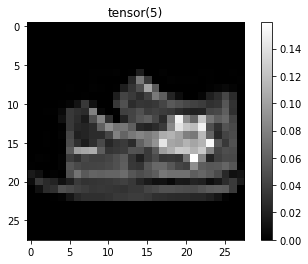

In [12]:
plt.imshow(f_x_test[-1].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.title(f_y_test[-1])

In [13]:
import torch.nn as nn
import time

epsilons = torch.Tensor([0.01, 0.03, 0.07, 0.1])
acc_results_non = dict()
verbose = False
criterion = nn.CosineEmbeddingLoss()
N_VAL_SAMPLES = f_x_test.data.shape[0]

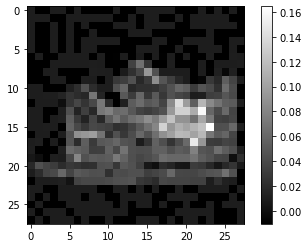


FGSM Attack with epsilon = 0.01000 | Elapsed time: 88.35 seconds.
Accuracy: Before the attack -> 81.96%	|	After the attack -> 72.88%


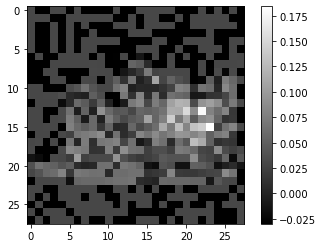


FGSM Attack with epsilon = 0.03000 | Elapsed time: 84.35 seconds.
Accuracy: Before the attack -> 81.96%	|	After the attack -> 22.45%


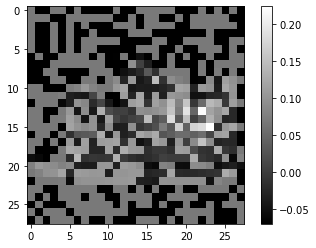


FGSM Attack with epsilon = 0.07000 | Elapsed time: 84.80 seconds.
Accuracy: Before the attack -> 81.96%	|	After the attack -> 10.00%


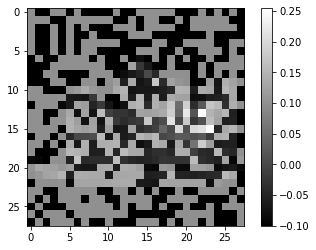


FGSM Attack with epsilon = 0.10000 | Elapsed time: 86.80 seconds.
Accuracy: Before the attack -> 81.96%	|	After the attack -> 10.00%


In [23]:
attack_sample = {'0.01':torch.zeros(10000, 28, 28),
                 '0.03':torch.zeros(10000, 28, 28),
                 '0.07':torch.zeros(10000, 28, 28),
                 '0.1':torch.zeros(10000, 28, 28)}

for eps in epsilons:
    correct_unperturbed = 0
    correct_perturbed = 0
    t0 = time.perf_counter()

    attack = torch.zeros(10000, 28, 28)
    labels = torch.zeros(10000)
    
    for j in range(len(f_x_test)):
    ### NOTE: IT WOULD BE MORE EFFICIENT TO ITERATE ONLY ONCE THROUGH THE DATA AND PERFORM ALL THE ATTACKS
        x_origin, y_target = f_x_test[j], f_y_test[j]
        x_origin, y_target = x_origin.to(device), y_target.to(device)
        x_origin.requires_grad = True

        y_pred = Fmodel(x_origin.reshape(-1, 784))
        
        if y_pred == y_target:
            correct_unperturbed += 1
            
        label = torch.ones(f_classes, dtype=int) * -1
        label[y_target.item()] = 1
        # Calculate loss and gradient
        output = Fmodel.encode(x_origin.reshape(-1, 784))
        loss = criterion(output, Fmodel.model, label)
        grad = torch.autograd.grad(outputs=loss, inputs=x_origin)[0]

        perturbed_x, _ = fgsm_attack(x_origin, epsilon=eps, gradient=grad)
        perturbed_output = Fmodel(perturbed_x.reshape(-1, 784))            
            
        if perturbed_output == y_target:
            correct_perturbed += 1
        
        attack[j] = perturbed_x.reshape(28, 28)
        labels[j] = y_target
                
    if eps == 0.1:
        attack_sample['0.1'] = attack
    elif eps == 0.07:
        attack_sample['0.07'] = attack
    elif eps == 0.03:
        attack_sample['0.03'] = attack
    else:
        attack_sample['0.01'] = attack  
        
    plt.imshow(perturbed_x.detach().numpy().reshape(28, 28), cmap='gray')
    plt.colorbar()
    plt.show()
    acc_before_attack = correct_unperturbed / N_VAL_SAMPLES
    acc_after_attack = correct_perturbed / N_VAL_SAMPLES
    print(f'\nFGSM Attack with epsilon = {eps:.5f} | Elapsed time: {time.perf_counter() - t0:.2f} seconds.')
    print(f'Accuracy: Before the attack -> {100 * acc_before_attack:.2f}%\t|\tAfter the attack -> {100 * acc_after_attack:.2f}%')
    acc_results_non[eps.item()] = acc_after_attack
acc_results_non[0] = acc_before_attack

In [24]:
import pickle 

data = {'data' : attack_sample,
        'label' : labels}

with open('FMNIST_FGSM_HD.pickle', 'wb') as f:
    pickle.dump(data, f)

In [25]:
for eps in attack_sample.keys():
    attack_norm = attack_sample[eps].detach().numpy().reshape(-1, 784)
    attack_norm = f_scaler.transform(attack_norm)
    attack_sample[eps] = torch.from_numpy(attack_norm).float()

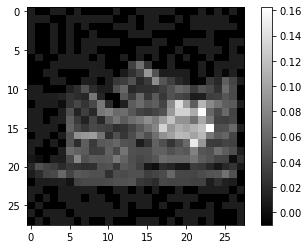

In [26]:
plt.imshow(attack_sample['0.01'][-1].reshape(28, 28), cmap='gray')
plt.colorbar()

In [29]:
print('Validating...')
yhat = Fmodel(f_x)
yhat_test = Fmodel(f_x_test)
yhat_attack_001 = Fmodel(attack_sample['0.01'])
yhat_attack_003 = Fmodel(attack_sample['0.03'])
yhat_attack_007 = Fmodel(attack_sample['0.07'])
yhat_attack_010 = Fmodel(attack_sample['0.1'])

acc = (f_y == yhat).float().mean()
acc_test = (f_y_test == yhat_test).float().mean()
acc_attack_001 = (labels == yhat_attack_001).float().mean()
acc_attack_003 = (labels == yhat_attack_003).float().mean()
acc_attack_007 = (labels == yhat_attack_007).float().mean()
acc_attack_010 = (labels == yhat_attack_010).float().mean()

print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{acc_attack_001 = :6f}')
print(f'{acc_attack_003 = :6f}')
print(f'{acc_attack_007 = :6f}')
print(f'{acc_attack_010 = :6f}')

Validating...
acc = 0.833617
acc_test = 0.819600
acc_attack_001 = 0.732200
acc_attack_003 = 0.359000
acc_attack_007 = 0.100000
acc_attack_010 = 0.100000
